### FWI using horizontal DAS cable.
The VP, VS, and Density parameterization is used.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [11]:
font_size = 14
params = {
    'image.cmap': 'seismic',
    'axes.grid': False,
    'savefig.dpi': 300,   # to adjust notebook inline plot size
    'axes.labelsize': font_size, # fontsize for x and y labels (was 10)
    'axes.titlesize': font_size,
    'font.size': font_size, 
    'legend.fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size
}
plt.rcParams.update(params)

In [12]:
# set up model size
nx = 201
nz = 101
dx = 20.0
dz = 20.0
dt = 0.002
nt = 1501
x = np.arange(0, nx * dx, dx)
z = np.arange(0, nz * dz, dz)

# true model
vp = np.ones((nx, nz)) * 4000.0
vs = np.ones((nx, nz)) * 4000.0 / 1.732
rho = np.ones((nx, nz)) * 2500.0

# set anomaly scale
scale_vp = 80.0
scale_vs = 80.0 / 1.732
scale_rho= 40

vp[42:58, 42:58] += scale_vp
vs[92:108, 42:58] -= scale_vs
rho[142:158, 42:58] += scale_rho

# initial model
vp_init = np.ones((nx, nz)) * 4000.0
vs_init = np.ones((nx, nz)) * 4000.0 / 1.732
rho_init = np.ones((nx, nz)) * 2500.0

# set source and receiver
ind_src_x =   np.arange(10, nx-10, 10).astype(int)
ind_src_z = 1*np.ones(ind_src_x.shape[0]).astype(int)
ind_rec_x =   np.arange(10, nx-10).astype(int)
ind_rec_z =95*np.ones(ind_rec_x.shape[0]).astype(int)

In [13]:
# save model
path_save = './Models/'
np.savetxt(path_save+"Anomaly_P-WAVE_VELOCITY_101_201.txt", vp.T)
np.savetxt(path_save+"Anomaly_S-WAVE_VELOCITY_101_201.txt", vs.T)
np.savetxt(path_save+"Anomaly_DENSITY_101_201.txt",        rho.T)
np.savetxt(path_save+"Anomaly_P-WAVE_VELOCITY_101_201_init.txt", vp_init.T)
np.savetxt(path_save+"Anomaly_S-WAVE_VELOCITY_101_201_init.txt", vs_init.T)
np.savetxt(path_save+"Anomaly_DENSITY_101_201_init.txt",        rho_init.T)

In [5]:
# clean up previous data
! rm -r /scratch/users/haipeng/Anomaly-Vp-Vs-Den

In [6]:
# run forward simulation to generate obs data
! python Main-001-FWI-Anomaly-Vp-Vs-Den.py --generate_data --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
vp_true_pad shape = (192, 265)
End of Data Generation


In [7]:
# run FWI using the Vp, Vs, and Density parameterization
! python Main-001-FWI-Anomaly-Vp-Vs-Den.py --nIter 100 --ngpu 4

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        60903     M =            5
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51116D+04    |proj g|=  2.14289D+00

At iterate    1    f=  1.13748D+04    |proj g|=  1.67266D+00

At iterate    2    f=  3.05521D+03    |proj g|=  6.46468D-01

At iterate    3    f=  2.11215D+03    |proj g|=  6.34151D-01

At iterate    4    f=  1.41392D+03    |proj g|=  2.55909D-01

At iterate    5    f=  1.03573D+03    |proj g|=  2.31604D-01

At iterate    6    f=  7.60082D+02    |proj g|=  3.12521D-01

At iterate    7    f=  5.78702D+02    |

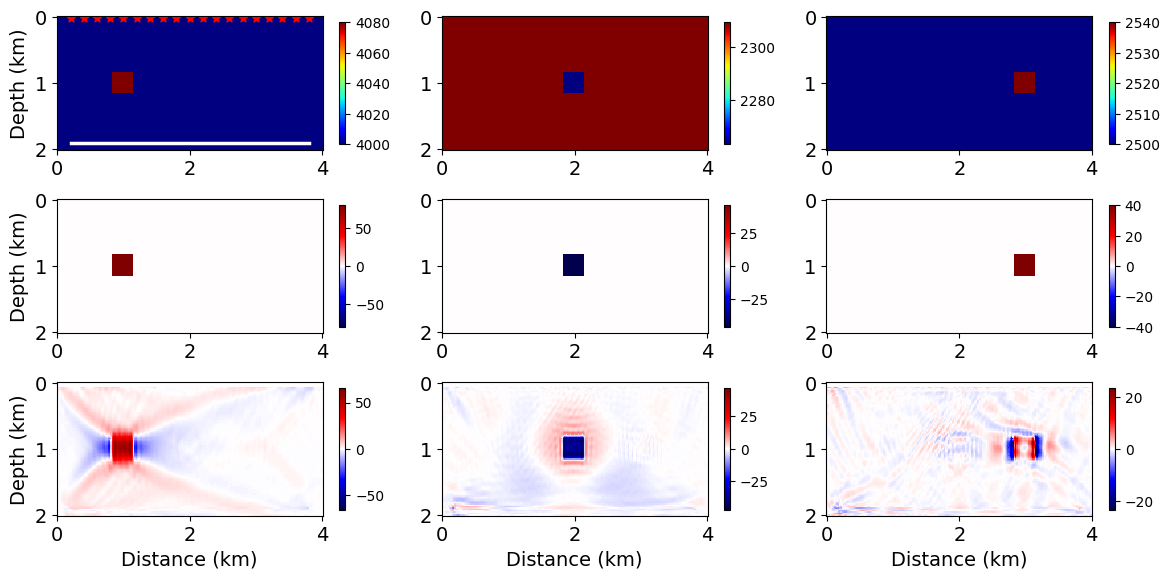

In [14]:
# plot the results

ite = 99
work_path = '/scratch/users/haipeng/Anomaly-Vp-Vs-Den'
vp_fwi  = sio.loadmat(work_path + f'/Results/Vp{ite}.mat')['Vp'].T
vs_fwi  = sio.loadmat(work_path + f'/Results/Vs{ite}.mat')['Vs'].T
rho_fwi = sio.loadmat(work_path + f'/Results/Den{ite}.mat')['Den'].T

fig = plt.figure(figsize=(12, 6))
data = [vp, vs, rho, vp-vp_init, vs-vs_init, rho-rho_init, vp_fwi-vp_init, vs_fwi-vs_init, rho_fwi-rho_init]
for i, data in enumerate(data):
    
    ax = fig.add_subplot(3, 3, (i+1))

    if i < 3:
        im = ax.pcolor(x/1000, z/1000, data.T, cmap ='jet')
    else: 
        im = ax.pcolor(x/1000, z/1000, data.T, cmap ='seismic', vmin = -abs(data).max(), vmax= abs(data).max())
    if i == 0:
        ax.plot(ind_rec_x * dx/1000, ind_rec_z * dz/1000, 'w-', linewidth=2.5)
        ax.scatter(ind_src_x * dx/1000, ind_src_z * dz/1000, color='r', marker = '*')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().invert_yaxis()
    colorbar = fig.colorbar(im, shrink=0.8)
    colorbar.ax.tick_params(labelsize=10)
    
    ax.set_aspect('equal')
    if i > 5:
        plt.xlabel('Distance (km)', fontsize=14)
    if i % 3 == 0:
        plt.ylabel('Depth (km)', fontsize=14)

plt.tight_layout()
plt.savefig('./Fig/FWI-Anomaly-Vp-Vs-Den.png', dpi=300, bbox_inches='tight')

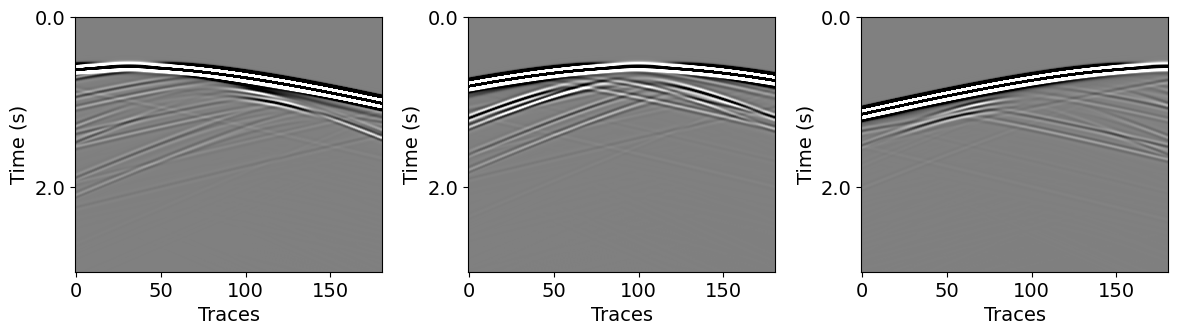

In [9]:
sg1 = np.fromfile(f'{work_path}/Data/Shot_ett{3}.bin',  dtype=np.float32).reshape(-1, nt)
sg2 = np.fromfile(f'{work_path}/Data/Shot_ett{10}.bin', dtype=np.float32).reshape(-1, nt)
sg3 = np.fromfile(f'{work_path}/Data/Shot_ett{18}.bin', dtype=np.float32).reshape(-1, nt)

t = np.arange(0, nt)*dt
off = np.arange(np.size(ind_rec_x))

fig = plt.figure(figsize=(12, 12))
for i, sg in enumerate([sg1, sg2, sg3]):
    plt.subplot(1,3,i+1)
    clim = np.percentile(np.absolute(sg), 95)
    plt.imshow(sg.T, aspect=0.1, cmap='gray', vmin = -clim, vmax=clim)
    plt.yticks(np.arange(0,  nt + 100, 1000), np.arange(0,  nt + 100, 1000) * dt)
    plt.xlabel('Traces')
    plt.ylabel('Time (s)')
    
plt.tight_layout()
# plt.savefig('./Fig/FWI-Anomaly-Vp-Vs-Den-waveform.png', dpi=300, bbox_inches='tight')